# Coefficent of Variation Jupyter Notebook

Python code to implement coefficient of variation (CV) for crop/non-crop classification using a Receiver Operating Characteristic (ROC) curve for a time-series of SAR images. This notebook is designed to handle a time series of SAR images for one Sentinel-1 frame. Loading merged SAR images for more than one frame may exceed memory space. The notebook statistically calculates the CV for a stack of time-series imagery. The CV output is then used to generate a ROC curve by using the Copernicus Global Land Service Land Cover layer (CGLS-LC) for time series through 2019 and  ESA WorldCover for 2020 and beyond as ground truth. We will refer to them both as the the Global Land Cover  (GLC). The GLC is downloaded from an Amazon S3 bucket. If the area spanned by the SAR images spans more than one GLC tile, then multiple GLC tiles are merged. Pixels classified by the GLC as "Water" are masked and not used in classification because water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often misclassified because of this. The J statistic (Youden's Index) is calculated to determine the ideal threshold on the curve to use for best classification results. The accuracy of the classification compared to the GLC as ground truth are calculated for the CV crop/non-crop classification. The classified image is exported as a Geotiff. A CSV file is exported containing accuracy statistics for the classification as well as the land cover types resulting is misclassifications.

Coefficient of Variation is calculated by: Standard Deviation/Mean

Created by: Shannon Rose, Microwave Remote Sensing Labratory (MIRSL) Unuversity of Massachusetts- Amherst

Modified by: Kaylee Sharp (kaylee.g.sharp@nasa.gov / kaylee.sharp@uah.edu), University of Alabama in Huntsville (January 2023)

Dataset needed: Timeseries of SAR imagery
    
OSL Kernel: hydrosar

# Flowchart

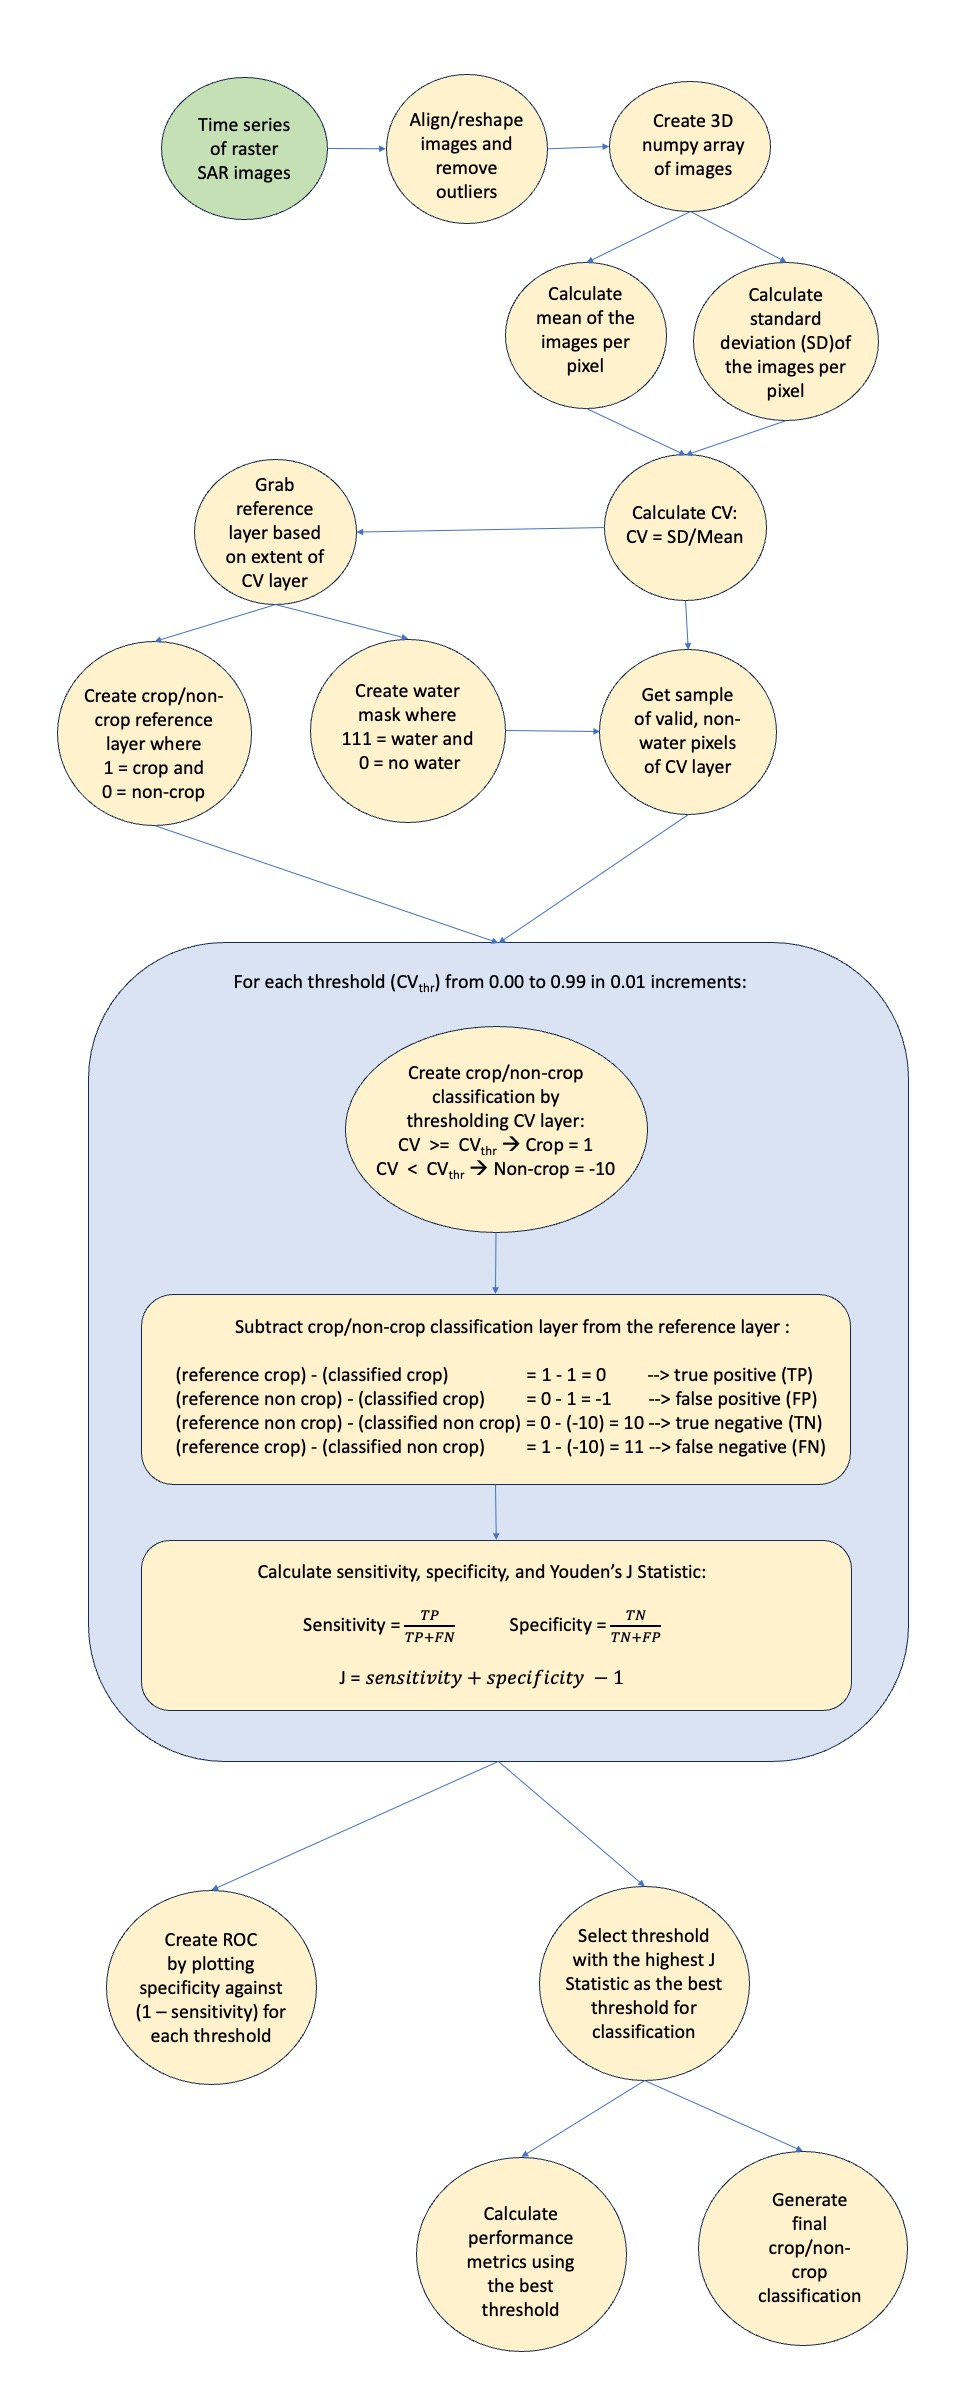

# Imports and Inputs

This code requires Python 3.7 or higher and requires the packages imported below, some of which may need to be added to your conda environment.

In [ ]:
import geopandas as gpd
import glob
from IPython.display import Image
import numpy as np
import math
from matplotlib.pyplot import figure
import matplotlib.colors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
import os
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import random
import rasterio as rio
from rasterio.plot import show_hist
import requests
from shapely.geometry import box
import shutil
import sklearn
from sklearn import metrics
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 14})

Required inputs: SAR_image_folder
- SAR_image_folder = path to the directory holding the SAR images

Optional inputs: Output_folder, glc_folder
- Output_folder = path to an existing directory to store all outputs
- glc_folder = path to an existing directory containing GLC files. Use this input when you wish to reuse GLC files from a previous run of the notebook to avoid redownloading and preparing the GLC unnecessarily.

In [ ]:
# (Required) Insert full path to directory holding the SAR images.
# e.g. '/home/jovyan/notebooks/ASF/Projects/Ethiopia/2018_Ethiopia/RTC_GAMMA_tiffs'
SAR_image_folder = '/home/jovyan/notebooks/ASF/Projects/Brazil/RTC_GAMMA_tiffs'

# (Optional) Insert full path to an existing directory holding necessary GLC files.
# e.g. '/home/jovyan/notebooks/ASF/Projects/Ethiopia/2018_Ethiopia/glc/'
# If no GLC folder is found containing the necessary files, 
# a GLC directory will be created in the parent directory of SAR_image_folder
glc_folder = None

# (Optional) Insert full path to an existing directory to store all outputs.
# e.g. '/home/jovyan/notebooks/ASF/Projects/Ethiopia/2018_Ethiopia/output/'
# If no output folder is found, an output directory will be created in the parent directory of SAR_image_folder
Output_folder = None

# change sample size here
# e.g. p = 0.1 --> sample size of 0.1% of classifiable pixels (not water or NaN)

p = 0.1

p_string = str(p).replace('.', '_')

The following cells check if:
- The SAR folder exits and contains files.
- The inputted output folder exists and contains the necessary files.
- The inputted GLC folder exists and contains the necessary files.

These cells also create an output folder and GLC folder if no paths are inputted above and no preexisting output/GLC directories are found.

In [ ]:
# Checking for SAR folder.
if os.path.exists(SAR_image_folder) and len(os.listdir(SAR_image_folder)) != 0:
    print('SAR image folder exists and contains files.')
    SAR_images = sorted(glob.glob(os.path.join(SAR_image_folder,"*.tif*")))
    start_SAR_image_filename_parts = SAR_images[0].split('/')[-1].split('_')
    end_SAR_image_filename_parts = SAR_images[-1].split('/')[-1].split('_')
    start_date = next(part.split('T')[0] for part in start_SAR_image_filename_parts if part[0] == '2')
    end_date = next(part.split('T')[0] for part in end_SAR_image_filename_parts if part[0] == '2')
    year = start_date[0:4]
else:
    print('SAR image folder either does not exist or contains no files.')

In [ ]:
# Checking for GLC Folder
if glc_folder:
    if not os.path.exists(glc_folder):
        print('Inputted GLC folder does not exist.')
        print("Before continuing, correct glc_folder above or set to None to create a GLC folder in:", Path(SAR_image_folder).parents[0])
    else:
        print("GLC directory already found.")
    
else:
    glc_folder = os.path.join(Path(SAR_image_folder).parents[0], "glc")
    try:
        os.mkdir(glc_folder)
        print(f"Created GLC directory: {glc_folder}")
    except FileExistsError:
        print("GLC directory found.")               

In [ ]:
# Searching for GLC files
try:
    glc_reclass_path = glob.glob(os.path.join(glc_folder, '*Reclass.tif'))[0]
    glc_water_path = glob.glob(os.path.join(glc_folder, '*waterMask.tif'))[0]
    glc_clip_path = glob.glob(os.path.join(glc_folder, 'glc_clipped.tif'))[0]
    print(f"Files found: \n {glc_reclass_path} \n {glc_water_path} \n {glc_clip_path}")
    print("\nIf you wish to use these files for the analysis, skip the 'GLC Preparation' section.")
    print("\nIf not, running the 'GLC Preparation' section will overwrite these files.")
except IndexError:
    print(f"GLC tile(s) will be downloaded into {glc_folder}")

In [ ]:
# Checking for Output Folder
if Output_folder:
    if not os.path.exists(Output_folder):
        print('Inputted Output folder does not exist.')
        print("Before continuing, correct Output_folder above or set to None to create a Output folder in:", Path(SAR_image_folder).parents[0])
    else:
        print('Output folder found')
else:
    Output_folder = os.path.join(Path(SAR_image_folder).parents[0], "output")
    try: 
        os.mkdir(Output_folder)
        print(f"Created output directory: {Output_folder}")
    except FileExistsError:
        print("Output directory found.")

In [ ]:
# Checking for CV file
CV_tif_path = os.path.join(Output_folder, f'CoVar_{start_date}_{end_date}_p_{p_string}.tif')
if os.path.isfile(CV_tif_path):
    print('CV file found:', CV_tif_path)
    print('Opening file ...')
    CV = gdal.Open(CV_tif_path).ReadAsArray()
    print("\nIf you wish to use this file for the analysis, you can skip the 'Process SAR Images' and 'Coefficient of Variaton' sections.")
    print("\nIf not, running those sections will overwrite this file.")
else:
    print('No CV file found.')

## Functions

Write functions to be used later.

The function reproject_image_to_reference reprojects an input file to match the extent, resolution, and projection of a reference file.

The function write_geotiff_export writes an array to a geotiff.

In [ ]:
# Added by Jordan Bell on 11/9/2021
# from https://github.com/jgomezdans/eoldas_ng_observations/blob/reference/eoldas_ng_observations/eoldas_observation_helpers.py#L29
def reproject_image_to_reference(reference, input_file, output_file, res=None): 
    """This function reprojects an image (``input_file``) to
    match the extent, resolution and projection of another
    (``reference``) using GDAL. The newly reprojected image
    is a GDAL VRT file for efficiency. A different spatial
    resolution can be chosen by specifyign the optional
    ``res`` parameter. The function returns the new file's
    name.
    Parameters
    -------------
    reference: str 
        A filename (with full path if required) with the 
        reference image (that that will be taken as a reference)
    input_file: str 
        A filename (with path if needed) with the image
        that will be reprojected
    res: float, optional
        The desired output spatial resolution, if different 
        to the one in ``reference``.
    Returns
    ----------
    The reprojected filename
    TODO Have a way of controlling output filename
    """
    input_file_ds = gdal.Open( input_file )
    if input_file_ds is None:
        print("GDAL could not open input_file file %s " % input_file)
    input_file_proj = input_file_ds.GetProjection()
    input_file_geotrans = input_file_ds.GetGeoTransform()
    data_type = input_file_ds.GetRasterBand(1).DataType
    n_bands = input_file_ds.RasterCount

    reference_ds = gdal.Open( reference )
    if reference_ds is None:
        print("GDAL could not open reference file %s " % reference)
    reference_proj = reference_ds.GetProjection()
    reference_geotrans = reference_ds.GetGeoTransform()
    w = reference_ds.RasterXSize
    h = reference_ds.RasterYSize
    if res is not None:
        reference_geotrans[1] = float( res )
        reference_geotrans[-1] = - float ( res )

    dst_filename = output_file
    dst_ds = gdal.GetDriverByName('GTiff').Create(dst_filename,
                                                w, h, n_bands, data_type)
    dst_ds.SetGeoTransform( reference_geotrans )
    dst_ds.SetProjection( reference_proj)

    gdal.ReprojectImage( input_file_ds, dst_ds, input_file_proj,
                         reference_proj, gdal.GRA_NearestNeighbour)
    dst_ds = None  # Flush to disk
    return dst_filename

# Define write_geotiff function - writes an array to a geotiff
def write_geotiff_export(image, geotrans, cols, rows, spatial_ref, nodata, outfilename):    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(outfilename, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform(geotrans)
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(image)
    outRasterSRS = osr.SpatialReference()
    outband.SetNoDataValue(np.nan)
    outRasterSRS.ImportFromWkt(spatial_ref)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

# Process SAR Images

The SAR images should all be the same Path/Row. However, these images will vary in size and occasionally an image will not align well with the other images in the stack. Therefore in the first cell we look through the SAR images and find any images whose extents vary considerably from the other images. These images are removed from the stack. If you wish to use all images, do not run the first cell below. This may result in a smaller Coefficient of Variation map than expected.

The second cell will check if SAR images we've elected to process have the same shape and coordinate reference system. All images should have the same coordinate reference system, but they will likely differ slightly in shape. 

The third cell find the shape of the smallest image and clip any larger images to that size. The clipping does not permanently change the files in memory. This cell also creates a mask for all of the zeros or no data values found in the SAR images. 

The last cell applies this mask to every SAR image ensuring that the only pixels we are processing are the pixels that contain data in every SAR image.  

In [ ]:
top_list = [rio.open(tif).bounds[-1] for tif in SAR_images]
top_range = max(top_list) - min(top_list)

if (top_range < 300):
    print('All images align')
    
else:
    top_avg = np.mean(top_list)
    top_std = np.std(top_list)

    outliers = []

    for tif in SAR_images:
        top = rio.open(tif).bounds[-1]
        if (top <= (top_avg - 3*top_std)) or (top >= (top_avg + 3*top_std)):
            outliers.append(tif)

    if len(outliers) == len(SAR_images):
          print('Too many outliers. Using all images.')
    elif outliers:
        outliers = set(outliers)
        print('Images whose extents do not match the other images and therefore excluded from analysis:\n')
        for outlier in outliers:
            print(outlier)
            SAR_images.remove(outlier)
    else:
        print('All images align.')

In [ ]:
## test for same shape and crs

shapes = []
all_crs = []
for image in SAR_images:
    im = rio.open(image)
    shapes.append((im.height, im.width))
    all_crs.append(im.crs)

test_for_same_shape = all(shape == shapes[0] for shape in shapes)
test_for_same_crs = all (crs == all_crs[0] for crs in all_crs)

if not test_for_same_shape:
    print("SAR images have different sizes. Proceed to the next cell to resolve size mismatch.")
else:
    print("SAR images are the same size.")
                          
if not test_for_same_crs:
    print("SAR images have different projections.")
else:
    print("SAR images have same projection.")

In [ ]:
all_bounds = np.array([rio.open(tif).bounds for tif in SAR_images])

bounds_maxs = np.max(all_bounds, axis=0)
bounds_mins = np.min(all_bounds, axis=0)

x_left = bounds_maxs[0]
y_bottom = bounds_maxs[1]
x_right = bounds_mins[2]
y_top = bounds_mins[3]

SAR_image_arrays = []
print("SAR images have different sizes. Working to resolve size mismatch.\n")
no_data_locs = []
for tif in SAR_images:
    print(tif)
    raster = rio.open(tif)
    bounds = raster.bounds
    left_shift = int((x_left - bounds[0])/30)
    bottom_shift = int((y_bottom - bounds[1])/30)
    right_shift = int((bounds[2] - x_right)/30)
    top_shift = int((bounds[3] - y_top)/30)
    tif_array = raster.read()[0]
    array_shape = tif_array.shape
    if bottom_shift == 0:
        col_right_index = array_shape[0]
    else:
        col_right_index=-bottom_shift
    if right_shift == 0:
        row_bottom_index = array_shape[1]
    else:
        row_bottom_index = -right_shift
    clipped_array = tif_array[top_shift:col_right_index, left_shift:row_bottom_index]
    SAR_image_arrays.append(clipped_array)
    no_data = np.where(clipped_array == 0)
    no_data_locs.append(no_data)
    
print('\nSize mismatch resolved')

SAR_zeros_mask = np.zeros(clipped_array.shape)
for nd_loc in no_data_locs:
    SAR_zeros_mask[nd_loc] = np.nan


SAR_stack = np.array(SAR_image_arrays, dtype=float)

del SAR_image_arrays

# Creating a variable for the number of images (one for each date)
num_dates = len(SAR_stack)
print ("Number of dates:", num_dates)
print(SAR_stack.shape)

rows = SAR_stack.shape[1]
cols = SAR_stack.shape[2]
geotransform = rio.transform.from_origin(x_left, y_top, 30, 30)
spatialref = raster.crs
datatype = SAR_stack.dtype

# Coefficient of Variation

CV = Standard Deviation / Mean

The coefficient of variation can exceed a value of 1. However, for the purposes of illustration, coefficient of variation values that exceed 1 are given a value of 1.

In [ ]:
# Calculate the mean for the time stack of images
mean = np.mean(SAR_stack, axis = 0)

# Calculate the standard deviation for the time stack of images
std = np.std(SAR_stack, axis = 0)

del SAR_stack

# Calculate the coefficient of variation for the time stack of images 
CV = std/mean

CV = CV + SAR_zeros_mask

plt.set_cmap('viridis')
plt.rcParams['figure.figsize'] = (6,5)
plt.imshow((CV),vmin=0,vmax=1)
plt.title('CoV')
plt.colorbar(fraction=0.046*mean.shape[0]/mean.shape[1],pad=0.04);

In [ ]:
# Saving CV GeoTIFF
CV_tif_path = os.path.join(Output_folder, f'CoVar_{start_date}_{end_date}_p_{p_string}.tif')

with rio.open(CV_tif_path, mode='w',
              driver="GTiff",
              height=rows,
              width=cols,
              count=1,
              dtype=datatype,
              crs=spatialref,
              transform=geotransform,
             ) as dst:
    dst.write(CV,1)
    
# Saving CV PNG
CV_png_path = os.path.join(Output_folder, f"CoVar_{start_date}_{end_date}_p_{p_string}.png")
plt.savefig(CV_png_path, dpi=300, bbox_inches = 'tight', transparent='true');

## Histogram of CV Values (Optional)

In [ ]:
fig = plt.figure(figsize=(12, 12)) # Initialize figure with a size
ax1 = fig.add_subplot(111)  # 221 determines: 2 rows, 2 plots, first plot
show_hist(np.clip(CV,0,1.0),bins=50, label='CoVar', ax=ax1)  # this is the only routine that uses rasterio

hist_path = os.path.join(Output_folder, "CoVar_Histogram.png")
plt.savefig(hist_path, dpi=300, bbox_inches = 'tight', transparent='true')

## Standard Deviation of Radar Cross Section (Optional)

In [ ]:
plt.imshow(std,vmin=0,vmax=0.02,interpolation='nearest');
plt.colorbar(fraction=0.046*std.shape[0]/std.shape[1],pad=0.04);
plt.title('Standard deviation of Radar Cross Section (magnitude)');

# GLC Preparation

This section : 
- grabs the GLC from the Amazon S3 bucket
- reprojects and clips the GLC to match the SAR images
- reclassifies the GLC to create a binary crop / non-crop layer for reference
- creates a water mask

## Grab GLC from S3 Bucket

In [ ]:
# Get the year
SAR_image_filename_parts = CV_tif_path.split('/')[-1].split('_')
year = next(part[0:4] for part in SAR_image_filename_parts if part[0] == '2')

#Reproject SAR image to WGS84
CV_tif = gdal.Open(CV_tif_path)
CV_tif_4326_path = os.path.join(glc_folder, "CV_tif_4326.tif")
warp = gdal.Warp(CV_tif_4326_path, CV_tif, dstSRS='EPSG:4326')
del warp
CV_tif_4326 = gdal.Open(CV_tif_4326_path)

if int(year) > 2021:
    print(f"No GLC available for {year}.")
    print("Using 2021 GLC instead.")
    year = '2021'

elif int(year) < 2015:
    print(f"No GLC available for {year}.")
    print("Using 2015 GLC instead")
    year = '2015'

if year in ['2015','2016', '2017', '2018', '2019']:
    
    # function for getting formatted longitude
    def get_lon(x):
        if x >= 0:
            direction = 'E'
        else: 
            direction = 'W'
        lon = direction + str(abs(x)).zfill(3)
        return lon
    
    # function for getting formatted latitude
    def get_lat(y):
        if y >= 0:
            direction = 'N'
        else:
            direction = 'S'
        lat = direction + str(abs(y)).zfill(2)
        return lat
    
    # get bounds of SAR image
    ulx, xres, xskew, uly, yskew, yres  = CV_tif_4326.GetGeoTransform()
    lrx = ulx + (SAR_tif_4326.RasterXSize * xres)
    lry = uly + (SAR_tif_4326.RasterYSize * yres)
    
    # Get longitudes and latitudes spanned by the SAR images.
    lon_values = list(range(math.floor(ulx/20) * 20, math.floor(lrx/20) * 20 + 1, 20))
    lat_values = list(range(math.ceil(lry/20) * 20, math.ceil(uly/20) * 20 +1, 20))

    # Grab all GLC tiles from S3 buckets spanned by the SAR images.
    for x in lon_values:
        for y in lat_values:
            lat_lon = get_lon(x) + get_lat(y)
            s3_url_base = f's3://vito.landcover.global/v3.0.1/{year}/{lat_lon}/'
            sys_output = subprocess.check_output(f"aws s3 ls --no-sign-request {s3_url_base} | grep Discrete-Classification-map_EPSG-4326.tif", shell=True)
            filename = sys_output.decode().split(" ")[-1].rstrip()
            com = f"aws s3 cp --no-sign-request {s3_url_base}{filename} {glc_folder}"
            os.system(com)
            print(lat_lon, "Done")
    print("All available GLC tiles downloaded.")
    glc_tiles = glob.glob(os.path.join(glc_folder, "*LC100*.tif"))

elif year in ['2020', '2021']:
    
    # load worldcover grid
    s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"
    grid_url = f'{s3_url_prefix}/v100/2020/esa_worldcover_2020_grid.geojson'
    grid = gpd.read_file(grid_url)
    
    # get bounds of SAR image
    CV_tif = rio.open(CV_tif_4326_path)
    bounds = CV_tif.bounds
    geom = box(*bounds)
    
    # find where SAR image bounds intersect worldcover grid
    tiles = grid[grid.intersects(geom)]
    
    # set algorithm version
    versions = {'2020': 'v100', '2021': 'v200'}
    version = versions[year]
    
    # download each GLC tile that intersects the SAR image
    for tile in tiles.ll_tile:
        com = f"aws s3 cp --no-sign-request s3://esa-worldcover/{version}/{year}/map/ESA_WorldCover_10m_{year}_{version}_{tile}_Map.tif {glc_folder}"
        os.system(com)
    print("All available GLC tiles downloaded.")
    glc_tiles = glob.glob(os.path.join(glc_folder, "ESA_WorldCover*.tif"))

else:
    print(f"No GLC available for {year}")

os.remove(CV_tif_4326_path)

# Merge GLC tiles using gdal if necessary.
if len(glc_tiles) > 1:
    print(f"Need to merge {len(glc_tiles)} GLC tiles.")
    glc_files_string = " ".join(glc_tiles)
    gdal_command = "gdal_merge.py -o " + os.path.join(glc_folder, "glc_merged.tif") + " -of gtiff " + glc_files_string
    os.system(gdal_command)
    print("GLC tiles merged!")
    for tile in glc_tiles:
        os.remove(tile)
    glc_path = glob.glob(os.path.join(glc_folder, "glc_merged.tif"))[0]
else:
    print("No merging required.")
    glc_path = glc_tiles[0]

## Reproject, Clip, and Reclass GLC

In [ ]:
# Reprojects and clips the GLC to the CV.
glc_clip_path = os.path.join(glc_folder, "glc_clipped.tif")
reproject_image_to_reference(CV_tif_path, glc_path, glc_clip_path)
os.remove(glc_path)

This cell reclassifies the GLC where:

Crop pixels = 1

Non-crop pixels = 0

In [ ]:
def glc_reclass(reference_in, wmoutput = False, output = False):
    
    glc_foler = Path(reference_in).parents[0]
       
    # Get dimensions of CDL
    ds = gdal.Open(reference_in)
    rows1 = ds.RasterYSize
    cols1 = ds.RasterXSize
    glc_in = ds.ReadAsArray(0, 0, cols1, rows1)

    GLC_geotransform = ds.GetGeoTransform()
    GLC_xres = GLC_geotransform[1]
    GLC_yres = -GLC_geotransform[5]
    GLC_xmin = GLC_geotransform[0]
    GLC_ymax = GLC_geotransform[3]
    GLC_spatialref = ds.GetProjectionRef()
    
    #Water Mask
    water_mask = np.zeros(np.shape(glc_in), dtype = 'byte')
    water_mask[(glc_in == 80) | (glc_in == 200) | (glc_in == 0)] = 1
    water_count = np.count_nonzero(water_mask == 1)

    filenamesplit = os.path.basename(reference_in)
    split = filenamesplit.split('.')

    filen = split[0]+ '_waterMask.tif' 
    filename = os.path.join(glc_foler, filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(glc_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(GLC_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(GLC_geotransform)
          out_ds.GetRasterBand(1).WriteArray(water_mask)
          out_ds = None

    GLC_crop = np.copy(glc_in)
    unique = np.unique(glc_in)
    uniquecount = len(unique)

    # Setting all crop classification values equal to 1 
    GLC_crop[glc_in == 40] = 1    # All Crops

    # Setting all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
    GLC_binary = np.copy(GLC_crop)
    GLC_binary[GLC_crop != 1]= 0

    plt.imshow(GLC_binary)

    # Getting the number of pixels classified as crop and non-crop including the removal of masked pixels
    cropcount = len(GLC_binary[np.where(GLC_binary == 1)])
    print("Number of crop pixels:", cropcount)

    noncount = len(GLC_binary[np.where(GLC_binary == 0)]) - water_count #-glcWater
    print("Number of non-crop pixels:",noncount)

    # Finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
    percent_crop_nonmasked_calc = round((cropcount / (cropcount + noncount))*100, 2)
    print ("% Crop: ", percent_crop_nonmasked_calc)
    percent_noncrop_nonmasked_calc = round((noncount / (cropcount + noncount))*100, 2)
    print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

    filen = split[0]+ '_Reclass.tif' 
    filename = os.path.join(glc_foler,  filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(glc_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(GLC_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(GLC_geotransform)
          out_ds.GetRasterBand(1).WriteArray(GLC_binary)
          out_ds = None
    return

In [ ]:
glc_reclass(glc_clip_path, wmoutput = True, output = True)

# Creating Watermask and Crop/Non-crop Binary from GLC

## Watermask

Water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often misclassified because of this.

This cell creates a water mask where:

Water pixels = 111

Non-water pixels = 0

In [ ]:
# load in watermask
glc_water = glob.glob(os.path.join(glc_folder, '*waterMask.tif'))[0]
watermask = gdal.Open(glc_water).ReadAsArray().astype('float32')
watermask[watermask == 1] = 111
watermask[np.where(np.isnan(CV))] = np.nan

#getting the number of pixels masked and not masked 
ref111 = np.count_nonzero(watermask == 111)
print("Number of masked Pixels:", ref111)
ref0 = np.count_nonzero(watermask == 0)
print("Number of pixels for classification:", ref0)
print('Water pixels are marked as blue')

# Display watermask
plt.rcParams['figure.figsize'] = (6,5)
water_nan_mask_colors = np.empty([watermask.shape[0],watermask.shape[1], 4])
water_nan_mask_colors[watermask == 0,:] = matplotlib.colors.to_rgba('green')
water_nan_mask_colors[watermask == 111,:] = matplotlib.colors.to_rgba('blue')
water_nan_mask_colors[watermask == np.nan,:] = matplotlib.colors.to_rgba('w')
plt.imshow(water_nan_mask_colors,interpolation='nearest');

## Crop/Non-crop Binary from GLC

This cell displays our crop / non-crop binary generated from the GLC and calculates:
- Number of crop pixels
- Number of non-crop, non-water pixels
- % of pixels that are crop pixels
- % of pixels that are non-crop pixels

In [ ]:
# load in binary GLC
glc_reclass = glob.glob(os.path.join(glc_folder, '*Reclass.tif'))[0]
glc_reclass_raster = gdal.Open(glc_reclass)

# get GLC spatial information
ref_geotransform = glc_reclass_raster.GetGeoTransform()
rows2 = glc_reclass_raster.RasterYSize
cols2 = glc_reclass_raster.RasterXSize
glc_spatialref = glc_reclass_raster.GetProjectionRef()

# get reference binary and mask NaN values
ref_binary = gdal.Open(glc_reclass).ReadAsArray().astype('float32')
ref_binary[np.where(np.isnan(CV))] = np.nan

# getting the number of pixels classified as crop and non-crop including the removal of masked pixels
cropcount = np.count_nonzero(ref_binary == 1)
print("Number of crop pixels:", cropcount)

noncount = np.count_nonzero(ref_binary == 0)- ref111
print("Number of non-crop pixels:",noncount)

# finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
percent_crop_nonmasked_calc = round((cropcount / ref0)*100, 2)
print ("% Crop: ", percent_crop_nonmasked_calc)

percent_noncrop_nonmasked_calc = round((noncount / ref0)*100, 2)
print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

# Display reference
plt.rcParams['figure.figsize'] = (6,5)
reference_colors = np.empty([ref_binary.shape[0],ref_binary.shape[1], 4])
reference_colors[ref_binary == np.nan,:] = matplotlib.colors.to_rgba('w')
reference_colors[ref_binary == 0,:] = matplotlib.colors.to_rgba('gray')
reference_colors[ref_binary == 1,:] = matplotlib.colors.to_rgba('gold')
plt.imshow(reference_colors,interpolation='nearest')
plt.title(f'Crop Reference ({percent_crop_nonmasked_calc}% crop)')
print('Crop pixels marked in yellow')

# Saving reference PNG
ref_binary_png_path = os.path.join(Output_folder, "ReferenceBinary.png") 
plt.savefig(ref_binary_png_path, dpi=300, bbox_inches = 'tight', transparent='true')

# Get Sample of CV

In these cells, we are selecting a sample of the valid, non-water pixels in both the CV layer and the GLC layer based on the sampling percentage (p) entered in the 'Imports and Inputs' section above.

In [ ]:
def reduce_size(percent):
    valid_pixels = np.where(watermask == 0)
    sample_size = int(len(valid_pixels[0]) * (percent/100))
    sample_list = random.sample(range(0,len(valid_pixels[0])-1), sample_size)
    sample_list_sorted = sorted(sample_list)
    _0_indices = np.array(valid_pixels[0][sample_list_sorted])
    _1_indices = np.array(valid_pixels[1][sample_list_sorted])
    return (_0_indices, _1_indices)

In [ ]:
if p < 100:
    sample_indices = reduce_size(p)
    sample = CV[sample_indices]
    glc_sample = ref_binary[sample_indices]
    print("Sample size:", len(sample))
else: 
    valid_pixels = np.where(watermask == 0)
    sample = CV[valid_pixels]
    glc_sample = ref_binary[valid_pixels]
    print("Using all pixels.")

# Coefficient of Variation Thresholding

We can determine the optimal threshold to divide our image into crop and non crop by finding the threshold where Youden's Index (J statistic) is highest. 

The highest Youden's Index is the point on the Receiver Operating Characteristic (ROC) curve where sensitivity and specificity are maximized, a maximum difference between the True Positive Rate (sensitivity) and False Positive Rate (1 - specificity). Later, a plot is generated to show where our optimal threshold falls on the ROC curve.

To find the optimal thresholds, we will test 100 thresholds (0.00, 0.01, 0.02, ... 0.99). Coefficient of variation may exceed 1. Therefore, all pixels with a CoV greater than 1 will be classified as crop at all thresholds.

For each of our 100 test thresholds:

1. Reclassify our Coefficient of Variation sample based on the threshold (apply_threshold() function below)
    
    CoV >= threshold --> 1 = crop
    
    CoV < threshold  --> -10 = non crop
    
    
2. Determine how our crop / non crop classification sample compares to the reference sample.

        
    Subtract our crop / non crop classification sample from the reference sample:
    
        reference crop     = 1
        reference non crop = 0
        
        (reference crop) - (classified crop)         = 1 - 1     = 0  --> true positive (TP)
        (reference non crop) - (classified crop)     = 0 - 1     = -1 --> false positive (FP)
        (reference non crop) - (classified non crop) = 0 - (-10) = 10 --> true negative (TN)
        (reference crop) - (classified non crop)     = 1 - (-10) = 11 --> false negative (FN)


3. Calculate sensitivity, specificity, and precision for each threshold. We also calculate (1 - specificity) for plotting the ROC curve.
    
    Sensitivity (Recall, True Positive Rate) = TP / (TP + FN)
    
    Specificity (True Negative Rate)         = TN / (TN + FP)
    
    Precision                                = TP / (TP + FP)
    
4. Calculate the J statistic for each threshold.

    J = sensitivity + specificity - 1
    

5. Sort the J statistics to determine which threshold results in the highest J statistic. This is our optimal threshold. 
    

## Picking a Threshold Based on the J statistic (Youden's Index)

In [ ]:
def apply_threshold(cv_sample, threshold):
    cv_sample_binary = np.empty(cv_sample.shape)
    cv_sample_binary[cv_sample >= threshold] = 1
    cv_sample_binary[cv_sample < threshold] = -10
    return cv_sample_binary

In [ ]:
tp_list = []
fp_list = []
tn_list = []
fn_list = []

thresholds = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

for threshold in thresholds:
    threshold_cv = apply_threshold(sample, threshold)
    ref_compare = np.subtract(glc_sample, threshold_cv)
    tp = np.count_nonzero(ref_compare == 0)
    tp_list.append(tp)
    fp = np.count_nonzero(ref_compare == -1)
    fp_list.append(fp)
    tn = np.count_nonzero(ref_compare == 10)
    tn_list.append(tn)
    fn = np.count_nonzero(ref_compare == 11)
    fn_list.append(fn)
    
#calculate sensitivity for each threshold
sensitivity = np.divide(tp_list, np.add(tp_list, fn_list))

#calculate specificity for each threshold
specificity = np.divide(tn_list, np.add(tn_list, fp_list))

#calculate (1 - specificity) for each threshold
sub_spec = np.subtract(1, specificity)
    
#calcluate j score for each threshold
j_stats = np.subtract(np.add(sensitivity, specificity), 1)

#zip thresholds to j scores, sort by j score
j_ordered = sorted(zip(j_stats,thresholds))

#threshold with highest j score is the best threshold
best_j_thresh = j_ordered[-1][1]
best_j_stat = j_ordered[-1][0]
print("Best Threshold: ", best_j_thresh)
print("Best J Score: ", round(best_j_stat, 2))

## Plotting the Receiver Operating Characteristic Curve

In [ ]:
## ROC curve

best_thresh_index = thresholds.index(best_j_thresh)   # getting the threshold picked by the J statistic
sub_specificity_ideal = sub_spec[best_thresh_index]   # getting (1 - specificity) at our threshold
sensitivity_ideal = sensitivity[best_thresh_index]    # getting sensitivity at our threshold

fig = plt.figure(figsize=(12, 12)) # Initialize figure with a size
ax1 = fig.add_subplot()
ax1.scatter(sub_spec, sensitivity) # plotting (1 - specificity) against sensitvity
ax1.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red") # plotting line of no discrimination
ax1.plot([sub_specificity_ideal], [sensitivity_ideal], marker='o', markersize=8, color="red") # plotting our optimal threshold


# plotting thresholds 0.1, 0.2, ... 0.9 
ax1.annotate('0.1', xy=(sub_spec[10], sensitivity[10]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,-30), textcoords = "offset points") 
ax1.annotate('0.2', xy=(sub_spec[20], sensitivity[20]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,-30), textcoords = "offset points") 
ax1.annotate('0.3', xy=(sub_spec[30], sensitivity[30]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (10,20), textcoords = "offset points")
ax1.annotate('0.4', xy=(sub_spec[40], sensitivity[40]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (-30,30), textcoords = "offset points")
ax1.annotate('0.5', xy=(sub_spec[50], sensitivity[50]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (-20,20), textcoords = "offset points")
ax1.annotate('0.6', xy=(sub_spec[60], sensitivity[60]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,20), textcoords = "offset points")
ax1.annotate('0.7', xy=(sub_spec[70], sensitivity[70]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,20), textcoords = "offset points")
ax1.annotate('0.8', xy=(sub_spec[80], sensitivity[80]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (30,20), textcoords = "offset points")
ax1.annotate('0.9', xy=(sub_spec[90], sensitivity[90]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (30,0), textcoords = "offset points")

#Setting plot layout

ax1.grid()

ax1.set_title('Receiver Operating Characteristic', fontsize=25)
#ax1.set_ylabel('True Positive Rate (sensitivity)', fontsize=20)
ax1.set_ylabel('Sensitivity', fontsize=20)
#ax1.set_xlabel('False Positive Rate (1-specificity)', fontsize=20)
ax1.set_xlabel('(1 - Specificity)', fontsize=20)
plt.rcParams['figure.figsize'] = (15,20)

# Saving ROC curve PNG
ROC_path = os.path.join(Output_folder, "ROC_curve.png")
plt.savefig(ROC_path, dpi=300, bbox_inches = 'tight', transparent='true')

# Performance Statistics

## Finding the AUC

Area Under the ROC curve (AUC) is a performance measurement (between 0 and 1) describing the discrimination power between the crop and non-crop classes. The higher the AUC value the better the model is at separating the two classes. An AUC value of 0.5 signifies there is no distinguishability between the classes. 

In [ ]:
ROC_AUC = round(sklearn.metrics.auc(sub_spec, sensitivity), 2)

print ("ROC Area Under Curve (AUC): ", ROC_AUC)

## Generate table of Performance Statistics

In [ ]:
def generate_accuracy_stats(threshold):
    
    # this list will hold all of our accuracy statisitcs for the specified threshold
    stats = []
    
    # adding the threshold to the list
    stats.append(threshold)
    
    # determine the difference between our reference layer and our reclassed CV
    valid_pixels = np.where(watermask == 0)
    sample = CV[valid_pixels]
    glc_sample = ref_binary[valid_pixels]
    total = len(sample)
    
    threshold_cv = apply_threshold(sample, threshold)
    ref_compare = np.subtract(glc_sample, threshold_cv)
    tp = np.count_nonzero(ref_compare == 0)
    fp = np.count_nonzero(ref_compare == -1)
    tn = np.count_nonzero(ref_compare == 10)
    fn = np.count_nonzero(ref_compare == 11)
    
    #calculate overall correct and overall incorrect pixels and add to the list
    p_crop_correct = tp/(total)              
    p_non_correct = tn/(total)
    p_crop_incorrect = fn/(total)
    p_non_incorrect = fp/(total)
    p_overall_correct = round((p_crop_correct + p_non_correct)*100, 2)
    stats.append(p_overall_correct)
    p_overall_incorrect = round((p_crop_incorrect + p_non_incorrect)*100, 2)
    stats.append(p_overall_incorrect)
    
    #add sensitivity, specificity, precision, and negative predictive value to list
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    neg_pred_val = tn / (tn + fn)
    j_stat = (sens + spec) - 1
    
    stats.append(round(j_stat, 2))
    stats.append(round(sens*100,2))
    stats.append(round(spec*100,2))
    stats.append(round(prec*100,2))
    stats.append(round(neg_pred_val*100,2))
    
    #Calculating Kappa Coefficient
    Total_correct = tp + tn

    Total_pixel_count = (total)

    Sum_of_products_crop_row = tp + fp
    Sum_of_products_non_row = tn + fn
    Sum_of_products_crop_col = tp + fn
    Sum_of_products_non_col = tn + fp

    Sum_of_products = (Sum_of_products_crop_row * Sum_of_products_crop_col) + (Sum_of_products_non_row * Sum_of_products_non_col)

    Kappa_coefficient = round((Total_pixel_count * Total_correct - Sum_of_products) / (Total_pixel_count * Total_pixel_count - Sum_of_products), 2)
    stats.append(Kappa_coefficient)
    
    #determine agreement based on Kappa coefficient
    if Kappa_coefficient <= 0.2:
        agreement = 'Poor'
    elif Kappa_coefficient <= 0.4:
        agreement = 'Fair'
    elif Kappa_coefficient <= 0.6:
        agreement = 'Moderate'
    elif Kappa_coefficient <= 0.8:
        agreement = 'Good'
    elif Kappa_coefficient > 0.8:
        agreement = 'Very good agreement'
        
    # add agreement to list
    stats.append(agreement)
    
    return stats

In [ ]:
# create dataframe for the accuracy statistics for the thresholds picked by the J score and the F1 score
accuracy_df = pd.DataFrame({"J": generate_accuracy_stats(best_j_thresh)})
accuracy_df.index = ["Threshold", "% Overall Correct (Accuracy)", "% Overall Incorrect", "J Statistic", "Sensitivity (Recall, TPR, Crop Producer's Accuracy)", "Specificity (TNR, Non-crop Producer's Accuracy)", "Precision (Crop User's Accuracy)", "Negative Predictive Value (Non-crop User's Accuracy)", "Kappa Coefficient", "Agreement"]
pd.set_option('max_colwidth', 400) # expands column width to fit row names
print(accuracy_df)

In [ ]:
#Exporting accuracy statistics as a CSV file

accuracy_table_path = os.path.join(Output_folder, f"accuracy_results_{start_date}_{end_date}_p_{p_string}.csv")
accuracy_df.to_csv(accuracy_table_path)

# Exporting Classified Image

In [ ]:
# Display binary classification
final_CV_reclass = np.empty(CV.shape)
final_CV_reclass[:] = np.nan
final_CV_reclass[np.where(CV >= best_j_thresh)] = 1
final_CV_reclass[np.where(CV < best_j_thresh)] = 0
final_CV_reclass[watermask == 111] = 0
plt.rcParams['figure.figsize'] = (8,8)
cmap = ListedColormap(["gray", "gold"])
plt.imshow(final_CV_reclass,interpolation='nearest',cmap=cmap);
plt.title(f'Final CV Classification ({best_j_thresh})');
print('Crop pixels marked in yellow (Crop=1, Non-Crop=0)')

cv_raster = gdal.Open(CV_tif_path)
rows = cv_raster.RasterYSize
cols = cv_raster.RasterXSize
geotransform = cv_raster.GetGeoTransform()
spatialref = cv_raster.GetProjectionRef()

# Saving binary classification GeoTIFF
J_CV_classification_binary_tif_path = os.path.join(Output_folder, f"CV_classification_binary_{start_date}_{end_date}_p_{p_string}.tif")
write_geotiff_export(final_CV_reclass, geotransform, cols, rows, spatialref, np.nan, J_CV_classification_binary_tif_path)

# Saving binary classification PNG
J_CV_classification_binary_png_path = os.path.join(Output_folder, f"CV_classification_binary_{start_date}_{end_date}_p_{p_string}.png")
plt.savefig(J_CV_classification_binary_png_path, bbox_inches = 'tight', transparent='true', dpi=300,)

# Breaking Down the False Positives

The GLC assigns a unique number to each land cover type (e.g. 40 = Cropland).

A false positive is a pixel that is not classified as cropland in the GLC, but is classified as crop in our binary crop/non-crop classification determined by our optimal CV threshold.

Steps to determine which land cover type resulted in a false positive:

1. Read in clipped GLC with original land cover codes and our binary crop/non-crop classification determined by our optimal CV threshold.

2. Create a false positives map where all pixels classified incorrectly as crops in our binary crop/non-crop classification map to 0 and all other values map to "NaN."

3. Add the GLC to our false positives map. Since false positives map to 0 in the false positives map, adding the GLC will reveal the land cover codes associated with each false positive pixel. Adding the GLC to the "NaN" pixels will result in a "NaN" pixel. 

4. Create a dataframe summarizing the land cover types associated with false positives, number of false positive pixels for each class, and the percentage of total false positives that are coming from each class. 

In [ ]:
# Dictionary to store associated GLC land cover codes and types
if int(year) <= 2019:
    GLC_LC_codes = {20: 'Shrubs', 30: 'Herbaceous Vegetation', 40: 'Cropland', 50: 'Built-up', 60: 'Bare/Sparse Vegetation',
                    70: 'Snow/Ice', 80: 'Permanent Water', 90: 'Herbaceous Wetland', 100: 'Moss/Lichen', 
                    111: 'Closed Forest, Evergreen Needle Leaf', 112: 'Closed Forest, Evergreen Broad Leaf',
                    113: 'Closed Forest, Deciduous Needle Leaf', 114: 'Closed Forest, Deciduous Broad Leaf',
                    115: 'Closed Forest, Mixed', 116: 'Closed Forest, Unknown', 121: 'Open Forest, Evergreen Needle Leaf',
                    122: 'Open Forest, Evergreen Broad Leaf', 123: 'Open Forest, Deciduous Needle Leaf',
                    124: 'Open Forest, Deciduous Broad Leaf', 125: 'Open Forest, Mixed',
                    126: 'Open Forest, Unknown', 200: 'Ocean/Major Water Bodies'}
elif int(year) >= 2020:
    GLC_LC_codes = {10: 'Tree Cover', 20: 'Shrubland', 30: 'Grassland', 40: 'Cropland',
                    50: 'Built-up', 60: 'Bare/Sparse Vegetation', 70: 'Snow and Ice',
                    80: 'Permanent Water Bodies', 90: 'Herbaceous Wetland',
                    95: 'Mangroves', 100: 'Moss and Lichen'}

In [ ]:
# Read in clipped GLC with original land cover codes
# Read in binary crop/non-crop classification from J statistic
glc_original = gdal.Open(glc_clip_path).ReadAsArray().astype('float')
j_class_raster = gdal.Open(J_CV_classification_binary_tif_path).ReadAsArray()

# Mask NaN values in clipped GLC
glc_original[glc_original == 0] = np.nan

# Reclass crop/non-crop classification so that false positive crop classifications map to 0
# and all else is 'NaN'
j_class_raster_copy = j_class_raster.copy()
j_class_raster_copy[j_class_raster == 0] = np.nan
j_class_raster_copy[j_class_raster == 1] = 0
j_class_raster_copy[glc_original == 40] = np.nan

# Get land cover codes and pixel counts for all positive crop classifications
fp_codes_counts = np.add(glc_original, j_class_raster_copy)
fp_codes, fp_counts = np.unique(fp_codes_counts, return_counts = True)
fp_codes_list = list(fp_codes)
fp_counts_list = list(fp_counts)

# Delete 'NaN' values
del fp_codes_list[-1]
del fp_counts_list[-1]

# Find percentage of false positive pixels attributed to each land cover class
fp_total = sum(fp_counts_list)
fp_percentages = list(fp_counts_list / fp_total)
fp_percentages = [round(percent*100, 2) for percent in fp_percentages]

# Zip land cover types, false positive counts, and percentages
# Sort by percentage false positive
fp_codes_list = [int(fp_code) for fp_code in fp_codes_list]
fp_types = [GLC_LC_codes[code] for code in fp_codes_list]
fp_zip = zip(fp_types, fp_counts_list, fp_percentages)
fp_sorted = sorted(fp_zip, key=lambda x: x[2], reverse=True)

# Compile data in pandas dataframe
fp_table = pd.DataFrame(fp_sorted, columns=['Land Cover Type', 'False Positive Count', 'Percent'])
pd.set_option('expand_frame_repr', False)
print("False Positives by Land Cover")
print(fp_table)

In [ ]:
# Export false postive table
fp_csv_file = os.path.join(Output_folder, f"fp_table_{start_date}_{end_date}_p_{p_string}.csv")
fp_table.to_csv(fp_csv_file, index=False)